In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset

In [2]:
mpl_df = pd.read_csv("/content/mpl_id_s14.csv")
attributes_df = pd.read_csv("/content/mlbb_heroes_attribute.csv")

## Check info of dataset

In [3]:
mpl_df.head()

,no,week,date,match,game,game_length,blue_team,blue_explaner,blue_jungler,blue_midlaner,blue_goldlaner,blue_roamer,red_team,red_explaner,red_jungler,red_midlaner,red_goldlaner,red_roamer,result
0,1,1,aug-9,1,1,22,TLID,Edith,Julian,Luo Yi,Moskov,Minotaur,FNOC,Arlott,Roger,Valentina,Harith,Chou,RED
1,2,1,aug-9,1,2,17,FNOC,Thamuz,Nolan,Valentina,Harith,Minotaur,TLID,Arlott,Joy,Vexana,Roger,Edith,BLUE
2,3,1,aug-9,2,1,13,DEWA,Hylos,Julian,Valentina,Claude,Edith,EVOS,Ruby,Nolan,Vexana,Moskov,Khufra,BLUE
3,4,1,aug-9,2,2,16,DEWA,X.Borg,Julian,Valentina,Moskov,Arlott,EVOS,Hylos,Roger,Zhask,Claude,Guinevere,RED
4,5,1,aug-9,2,3,23,DEWA,Paquito,Julian,Valentina,Moskov,Hylos,EVOS,X.Borg,Roger,Novaria,Harith,Guinevere,BLUE


In [4]:
attributes_df.head()

,id,hero,main_role,secondary_role,durability,offense,control_effects,difficulty,main_damage_type,early,mid,late
0,1,Miya,Marksman,NaN,1,7,4,1,physical,0,0,1
1,2,Balmond,Fighter,NaN,8,3,2,1,physical,1,1,0
2,3,Saber,Assassin,NaN,2,6,6,1,physical,0,1,0
3,4,Alice,Mage,Tank,5,5,7,7,magic,0,0,1
4,5,Nana,Mage,NaN,5,6,10,1,magic,0,0,1


In [5]:
mpl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   no              212 non-null    int64 
 1   week            212 non-null    int64 
 2   date            212 non-null    object
 3   match           212 non-null    int64 
 4   game            212 non-null    int64 
 5   game_length     212 non-null    int64 
 6   blue_team       212 non-null    object
 7   blue_explaner   212 non-null    object
 8   blue_jungler    212 non-null    object
 9   blue_midlaner   212 non-null    object
 10  blue_goldlaner  212 non-null    object
 11  blue_roamer     212 non-null    object
 12  red_team        212 non-null    object
 13  red_explaner    212 non-null    object
 14  red_jungler     212 non-null    object
 15  red_midlaner    212 non-null    object
 16  red_goldlaner   212 non-null    object
 17  red_roamer      212 non-null    object
 18  result    

In [6]:
attributes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                126 non-null    int64 
 1   hero              126 non-null    object
 2   main_role         126 non-null    object
 3   secondary_role    34 non-null     object
 4   durability        126 non-null    int64 
 5   offense           126 non-null    int64 
 6   control_effects   126 non-null    int64 
 7   difficulty        126 non-null    int64 
 8   main_damage_type  126 non-null    object
 9   early             126 non-null    int64 
 10  mid               126 non-null    int64 
 11  late              126 non-null    int64 
dtypes: int64(8), object(4)
memory usage: 11.9+ KB


check the class of column 'result'

In [7]:
mpl_df['result'].value_counts()

,count
result,
RED,106
BLUE,106


# Pre-prosessing data

## drop unused columns

In [8]:
# drop unused columns
mpl_df.drop(columns=['no','week','date','match','game','game_length','blue_team','red_team'], inplace=True)

In [9]:
# remove unused columns from dataset
attributes_df.drop(columns=['id','main_role','secondary_role','main_damage_type'], inplace=True)

## def functions

In [10]:
# Fungsi untuk menambahkan sum atribut untuk tiap side
def calculate_side_features(mpl_df, attribute_df):
    # Buat dictionary mapping hero untuk lookup cepat
    attribute_dict = attribute_df.set_index('hero')[['durability', 'offense', 'control_effects', 'difficulty', 'early', 'mid', 'late']].to_dict('index')

    # Fungsi internal untuk menghitung sum atribut dari satu sisi (blue atau red)
    def sum_attributes(row, side):
        positions = ['explaner', 'jungler', 'midlaner', 'goldlaner', 'roamer']
        features = ['durability', 'offense', 'control_effects', 'difficulty', 'early', 'mid', 'late']
        side_sums = {f"{side}_{feature}": 0 for feature in features}

        for pos in positions:
            hero = row[f"{side}_{pos}"]
            if hero in attribute_dict:
                for feature in features:
                    side_sums[f"{side}_{feature}"] += attribute_dict[hero][feature]

        return pd.Series(side_sums)

    # Apply fungsi di atas untuk setiap row di mpl_df
    blue_features = mpl_df.apply(lambda row: sum_attributes(row, 'blue'), axis=1)
    red_features = mpl_df.apply(lambda row: sum_attributes(row, 'red'), axis=1)

    # Gabungkan hasil ke mpl_df
    mpl_df = pd.concat([mpl_df, blue_features, red_features], axis=1)

    # Hitung total power spike untuk tiap side
    mpl_df['blue_total_power_spike'] = mpl_df[['blue_early', 'blue_mid', 'blue_late']].sum(axis=1)
    mpl_df['red_total_power_spike'] = mpl_df[['red_early', 'red_mid', 'red_late']].sum(axis=1)

    return mpl_df

In [11]:
# Fungsi untuk feature engineering pada DataFrame
def perform_feature_engineering(mpl_df):
    # Feature engineering berdasarkan perbedaan atribut
    mpl_df['durability_diff'] = mpl_df['blue_durability'] - mpl_df['red_durability']
    mpl_df['offense_diff'] = mpl_df['blue_offense'] - mpl_df['red_offense']
    mpl_df['control_effects_diff'] = mpl_df['blue_control_effects'] - mpl_df['red_control_effects']
    mpl_df['difficulty_diff'] = mpl_df['blue_difficulty'] - mpl_df['red_difficulty']
    mpl_df['power_spike_diff'] = mpl_df['blue_total_power_spike'] - mpl_df['red_total_power_spike']

    # Average nilai untuk role per team
    mpl_df['blue_avg_durability'] = mpl_df['blue_durability'] / 5
    mpl_df['red_avg_durability'] = mpl_df['red_durability'] / 5
    mpl_df['blue_avg_offense'] = mpl_df['blue_offense'] / 5
    mpl_df['red_avg_offense'] = mpl_df['red_offense'] / 5

    # Skor aggressiveness
    mpl_df['blue_aggressiveness_score'] = mpl_df['blue_offense'] / mpl_df['blue_durability']
    mpl_df['red_aggressiveness_score'] = mpl_df['red_offense'] / mpl_df['red_durability']

    # Perbandingan early-mid dan mid-late untuk tim blue
    mpl_df['blue_early_mid_ratio'] = np.where(mpl_df['blue_mid'] == 0, 1, mpl_df['blue_early'] / mpl_df['blue_mid'])
    mpl_df['blue_mid_late_ratio'] = np.where(mpl_df['blue_late'] == 0, 1, mpl_df['blue_mid'] / mpl_df['blue_late'])

    # Perbandingan early-mid dan mid-late untuk tim red
    mpl_df['red_early_mid_ratio'] = np.where(mpl_df['red_mid'] == 0, 1, mpl_df['red_early'] / mpl_df['red_mid'])
    mpl_df['red_mid_late_ratio'] = np.where(mpl_df['red_late'] == 0, 1, mpl_df['red_mid'] / mpl_df['red_late'])

    # Drop kolom posisi yang tidak dipakai
    mpl_df.drop(columns=[
        'blue_explaner', 'blue_jungler', 'blue_midlaner', 'blue_goldlaner', 'blue_roamer',
        'red_explaner', 'red_jungler', 'red_midlaner', 'red_goldlaner', 'red_roamer'
    ], inplace=True)

    # Drop kolom yang tidak diperlukan untuk model
    mpl_df = mpl_df.drop(columns=[
        'blue_durability', 'blue_offense', 'blue_control_effects', 'blue_difficulty',
        'red_durability', 'red_offense', 'red_control_effects', 'red_difficulty',
        'blue_total_power_spike',
        'blue_early', 'blue_mid', 'blue_late',
        'red_total_power_spike',
        'red_early', 'red_mid', 'red_late'
    ])

    return mpl_df

## pre-prosessing

In [12]:
# Contoh pemanggilan fungsi dengan mpl_df dan attributes_df
mpl_df_new = calculate_side_features(mpl_df, attributes_df)
mpl_df_new.head()

,blue_explaner,blue_jungler,blue_midlaner,blue_goldlaner,blue_roamer,red_explaner,red_jungler,red_midlaner,red_goldlaner,red_roamer,result,blue_durability,blue_offense,blue_control_effects,blue_difficulty,blue_early,blue_mid,blue_late,red_durability,red_offense,red_control_effects,red_difficulty,red_early,red_mid,red_late,blue_total_power_spike,red_total_power_spike
0,Edith,Julian,Luo Yi,Moskov,Minotaur,Arlott,Roger,Valentina,Harith,Chou,RED,27,26,35,19,2,3,3,26,27,23,30,3,3,2,8,8
1,Thamuz,Nolan,Valentina,Harith,Minotaur,Arlott,Joy,Vexana,Roger,Edith,BLUE,29,25,21,27,3,4,1,24,29,22,23,2,4,2,8,8
2,Hylos,Julian,Valentina,Claude,Edith,Ruby,Nolan,Vexana,Moskov,Khufra,BLUE,31,26,34,22,3,4,2,25,25,32,21,3,3,1,9,7
3,X.Borg,Julian,Valentina,Moskov,Arlott,Hylos,Roger,Zhask,Claude,Guinevere,RED,27,30,27,24,3,3,2,24,27,21,22,2,4,3,8,9
4,Paquito,Julian,Valentina,Moskov,Hylos,X.Borg,Roger,Novaria,Harith,Guinevere,BLUE,29,28,33,26,3,3,1,25,26,13,24,1,5,4,7,10


In [13]:
mpl_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   blue_explaner           212 non-null    object
 1   blue_jungler            212 non-null    object
 2   blue_midlaner           212 non-null    object
 3   blue_goldlaner          212 non-null    object
 4   blue_roamer             212 non-null    object
 5   red_explaner            212 non-null    object
 6   red_jungler             212 non-null    object
 7   red_midlaner            212 non-null    object
 8   red_goldlaner           212 non-null    object
 9   red_roamer              212 non-null    object
 10  result                  212 non-null    object
 11  blue_durability         212 non-null    int64 
 12  blue_offense            212 non-null    int64 
 13  blue_control_effects    212 non-null    int64 
 14  blue_difficulty         212 non-null    int64 
 15  blue_e

## Feature Enginering

In [14]:
# Contoh pemanggilan fungsi
mpl_df_transformed = perform_feature_engineering(mpl_df_new)
mpl_df_transformed.head()

,result,durability_diff,offense_diff,control_effects_diff,difficulty_diff,power_spike_diff,blue_avg_durability,red_avg_durability,blue_avg_offense,red_avg_offense,blue_aggressiveness_score,red_aggressiveness_score,blue_early_mid_ratio,blue_mid_late_ratio,red_early_mid_ratio,red_mid_late_ratio
0,RED,1,-1,12,-11,0,5.4,5.2,5.2,5.4,0.962963,1.038462,0.666667,1.0,1.0,1.500000
1,BLUE,5,-4,-1,4,0,5.8,4.8,5.0,5.8,0.862069,1.208333,0.750000,4.0,0.5,2.000000
2,BLUE,6,1,2,1,2,6.2,5.0,5.2,5.0,0.838710,1.000000,0.750000,2.0,1.0,3.000000
3,RED,3,3,6,2,-1,5.4,4.8,6.0,5.4,1.111111,1.125000,1.000000,1.5,0.5,1.333333
4,BLUE,4,2,20,2,-3,5.8,5.0,5.6,5.2,0.965517,1.040000,1.000000,3.0,0.2,1.250000


In [15]:
mpl_df_transformed = mpl_df_transformed.round(3)
mpl_df_transformed.head()

,result,durability_diff,offense_diff,control_effects_diff,difficulty_diff,power_spike_diff,blue_avg_durability,red_avg_durability,blue_avg_offense,red_avg_offense,blue_aggressiveness_score,red_aggressiveness_score,blue_early_mid_ratio,blue_mid_late_ratio,red_early_mid_ratio,red_mid_late_ratio
0,RED,1,-1,12,-11,0,5.4,5.2,5.2,5.4,0.963,1.038,0.667,1.0,1.0,1.500
1,BLUE,5,-4,-1,4,0,5.8,4.8,5.0,5.8,0.862,1.208,0.750,4.0,0.5,2.000
2,BLUE,6,1,2,1,2,6.2,5.0,5.2,5.0,0.839,1.000,0.750,2.0,1.0,3.000
3,RED,3,3,6,2,-1,5.4,4.8,6.0,5.4,1.111,1.125,1.000,1.5,0.5,1.333
4,BLUE,4,2,20,2,-3,5.8,5.0,5.6,5.2,0.966,1.040,1.000,3.0,0.2,1.250


check after feature enginering

In [16]:
mpl_df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   result                     212 non-null    object 
 1   durability_diff            212 non-null    int64  
 2   offense_diff               212 non-null    int64  
 3   control_effects_diff       212 non-null    int64  
 4   difficulty_diff            212 non-null    int64  
 5   power_spike_diff           212 non-null    int64  
 6   blue_avg_durability        212 non-null    float64
 7   red_avg_durability         212 non-null    float64
 8   blue_avg_offense           212 non-null    float64
 9   red_avg_offense            212 non-null    float64
 10  blue_aggressiveness_score  212 non-null    float64
 11  red_aggressiveness_score   212 non-null    float64
 12  blue_early_mid_ratio       212 non-null    float64
 13  blue_mid_late_ratio        212 non-null    float64

# Training

In [42]:
# Misalkan 'result' adalah target variable
X = mpl_df_transformed.drop(columns=['result'])  # Semua kolom kecuali 'result'
y = mpl_df_transformed['result']  # Kolom target

# Split dataset 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Cek ukuran dari masing-masing dataset
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 159
Test set size: 53


In [43]:
y_train.value_counts()

,count
result,
RED,80
BLUE,79


import libraries

In [53]:
# Melatih model Random Forest
rf_model = RandomForestClassifier(random_state=6)

# Cross Validation dengan 5 fold untuk Random Forest
rf_scores = cross_val_score(rf_model, X, y, cv=7)
print("Random Forest average accuracy:", rf_scores.mean())

Random Forest average accuracy: 0.5993855606758832


In [65]:
# Melatih model Random Forest
rf_model = RandomForestClassifier(random_state=10)
rf_model.fit(X_train, y_train)

# Melakukan prediksi pada data test
y_pred = rf_model.predict(X_test)

# Hitung akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

# Classification report
report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

Accuracy: 0.6226415094339622
Confusion Matrix:
[[15 12]
 [ 8 18]]
Classification Report:
              precision    recall  f1-score   support

        BLUE       0.65      0.56      0.60        27
         RED       0.60      0.69      0.64        26

    accuracy                           0.62        53
   macro avg       0.63      0.62      0.62        53
weighted avg       0.63      0.62      0.62        53



# Tunning Parameter

## manual tuning

In [66]:
for random in range(1, 22, 1):
  rf_model = RandomForestClassifier(random_state=random)
  rf_model.fit(X_train, y_train)
  y_pred = rf_model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print(f'random:{random} -  Your accuracy is: {accuracy:.3f}')

random:1 -  Your accuracy is: 0.566
random:2 -  Your accuracy is: 0.566
random:3 -  Your accuracy is: 0.604
random:4 -  Your accuracy is: 0.585
random:5 -  Your accuracy is: 0.566
random:6 -  Your accuracy is: 0.528
random:7 -  Your accuracy is: 0.585
random:8 -  Your accuracy is: 0.547
random:9 -  Your accuracy is: 0.604
random:10 -  Your accuracy is: 0.623
random:11 -  Your accuracy is: 0.585
random:12 -  Your accuracy is: 0.566
random:13 -  Your accuracy is: 0.585
random:14 -  Your accuracy is: 0.604
random:15 -  Your accuracy is: 0.528
random:16 -  Your accuracy is: 0.528
random:17 -  Your accuracy is: 0.547
random:18 -  Your accuracy is: 0.585
random:19 -  Your accuracy is: 0.604
random:20 -  Your accuracy is: 0.623
random:21 -  Your accuracy is: 0.585


In [68]:
for est in range(25, 101, 25):
  rf_model = RandomForestClassifier(n_estimators = est, random_state=10)
  rf_model.fit(X_train, y_train)
  y_pred = rf_model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print(f'n_estimators:{est} -  Your accuracy is: {accuracy:.2f}')

n_estimators:25 -  Your accuracy is: 0.60
n_estimators:50 -  Your accuracy is: 0.64
n_estimators:75 -  Your accuracy is: 0.60
n_estimators:100 -  Your accuracy is: 0.62


In [70]:
for depth in range(2,20,1):
  rf_model = RandomForestClassifier(max_depth=depth, n_estimators=50, random_state=10)
  rf_model.fit(X_train, y_train)
  y_pred = rf_model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print(f'max_depth:{depth} -  Your accuracy is: {accuracy:.3f}')

max_depth:2 -  Your accuracy is: 0.623
max_depth:3 -  Your accuracy is: 0.642
max_depth:4 -  Your accuracy is: 0.604
max_depth:5 -  Your accuracy is: 0.585
max_depth:6 -  Your accuracy is: 0.604
max_depth:7 -  Your accuracy is: 0.604
max_depth:8 -  Your accuracy is: 0.528
max_depth:9 -  Your accuracy is: 0.566
max_depth:10 -  Your accuracy is: 0.604
max_depth:11 -  Your accuracy is: 0.623
max_depth:12 -  Your accuracy is: 0.604
max_depth:13 -  Your accuracy is: 0.623
max_depth:14 -  Your accuracy is: 0.623
max_depth:15 -  Your accuracy is: 0.623
max_depth:16 -  Your accuracy is: 0.642
max_depth:17 -  Your accuracy is: 0.642
max_depth:18 -  Your accuracy is: 0.642
max_depth:19 -  Your accuracy is: 0.642


In [72]:
for split in range(2,11,1):
  rf_model = RandomForestClassifier(min_samples_split=split, max_depth=3, n_estimators=50, random_state=10)
  rf_model.fit(X_train, y_train)
  y_pred = rf_model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print(f'split:{split} -  Your accuracy is: {accuracy:.3f}')

split:2 -  Your accuracy is: 0.642
split:3 -  Your accuracy is: 0.642
split:4 -  Your accuracy is: 0.623
split:5 -  Your accuracy is: 0.623
split:6 -  Your accuracy is: 0.623
split:7 -  Your accuracy is: 0.604
split:8 -  Your accuracy is: 0.604
split:9 -  Your accuracy is: 0.623
split:10 -  Your accuracy is: 0.660


In [73]:
for leaf in range(2,11,1):
  rf_model = RandomForestClassifier(min_samples_leaf=leaf, min_samples_split=2, max_depth=3, n_estimators=50, random_state=10)
  rf_model.fit(X_train, y_train)
  y_pred = rf_model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print(f'leaf:{leaf} -  Your accuracy is: {accuracy:.2f}')

leaf:2 -  Your accuracy is: 0.64
leaf:3 -  Your accuracy is: 0.60
leaf:4 -  Your accuracy is: 0.62
leaf:5 -  Your accuracy is: 0.64
leaf:6 -  Your accuracy is: 0.60
leaf:7 -  Your accuracy is: 0.60
leaf:8 -  Your accuracy is: 0.64
leaf:9 -  Your accuracy is: 0.62
leaf:10 -  Your accuracy is: 0.66


In [74]:
rf_model = RandomForestClassifier(min_samples_leaf=10, min_samples_split=2, max_depth=3, n_estimators=50, random_state=10)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'leaf:{leaf} -  Your accuracy is: {accuracy:.2f}')

leaf:10 -  Your accuracy is: 0.66


## hyperparameter tunning

In [75]:
# Tentuin parameter grid
param_grid = {
    'n_estimators': [25, 50, 75, 100],
    'max_depth': [1, 2, 3],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [4, 6, 8, 10],
    'random_state': [4, 8, 10]
}

# Random Forest Model
rf = RandomForestClassifier()

# Grid Search untuk menemukan kombinasi hyperparameter terbaik
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=7, n_jobs=-1, verbose=2, scoring='accuracy')

# Melatih model dengan data training
grid_search.fit(X_train, y_train)

# Menampilkan hyperparameter terbaik
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Accuracy: {grid_search.best_score_:.2f}")


# Menggunakan model terbaik untuk prediksi
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Hitung akurasi
print(f'Accuracy: {accuracy:.2f}')

# Confusion matrix
print('Confusion Matrix:')
print(cm)

# Classification report
print('Classification Report:')
print(report)


Fitting 7 folds for each of 576 candidates, totalling 4032 fits
Best Hyperparameters: {'max_depth': 3, 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 8}
Best Accuracy: 0.60
Accuracy: 0.68
Confusion Matrix:
[[20  7]
 [10 16]]
Classification Report:
              precision    recall  f1-score   support

        BLUE       0.67      0.74      0.70        27
         RED       0.70      0.62      0.65        26

    accuracy                           0.68        53
   macro avg       0.68      0.68      0.68        53
weighted avg       0.68      0.68      0.68        53



/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [76]:
# Melatih model Random Forest
rf_model = RandomForestClassifier(
    random_state=8,
    n_estimators=50,
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=8,
)
rf_model.fit(X_train, y_train)

# Melakukan prediksi pada data test
y_pred = rf_model.predict(X_test)

# Hitung akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

# Classification report
report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

Accuracy: 0.68
Confusion Matrix:
[[20  7]
 [10 16]]
Classification Report:
              precision    recall  f1-score   support

        BLUE       0.67      0.74      0.70        27
         RED       0.70      0.62      0.65        26

    accuracy                           0.68        53
   macro avg       0.68      0.68      0.68        53
weighted avg       0.68      0.68      0.68        53



## try to randomized parameter

In [77]:
# Melatih model Random Forest
rf_model = RandomForestClassifier(
    random_state=91,
    n_estimators=50,
    max_depth=2,
    min_samples_split=2,
    min_samples_leaf=8,
)
rf_model.fit(X_train, y_train)

# Melakukan prediksi pada data test
y_pred = rf_model.predict(X_test)

# Hitung akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

# Classification report
report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

Accuracy: 0.70
Confusion Matrix:
[[18  9]
 [ 7 19]]
Classification Report:
              precision    recall  f1-score   support

        BLUE       0.72      0.67      0.69        27
         RED       0.68      0.73      0.70        26

    accuracy                           0.70        53
   macro avg       0.70      0.70      0.70        53
weighted avg       0.70      0.70      0.70        53



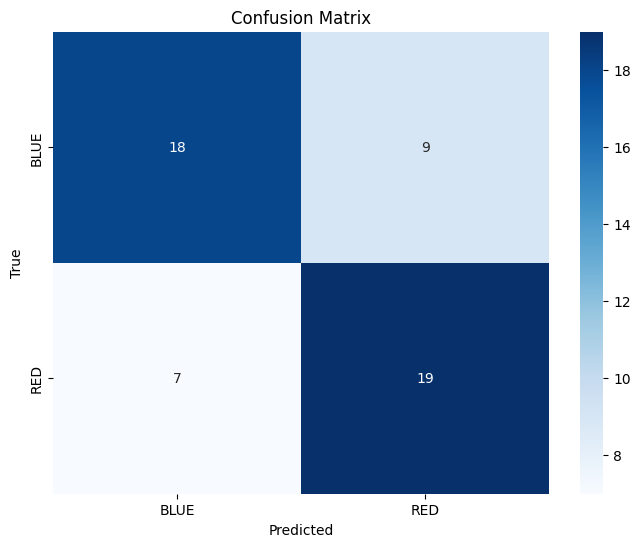

In [78]:
# Assuming cm is already calculated as in your provided code
# cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['BLUE', 'RED'], yticklabels=['BLUE', 'RED'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Test the model

In [79]:
mpl_df_test = pd.DataFrame({
    'blue_explaner': ['Chou'],
    'blue_jungler': ['Alpha'],
    'blue_midlaner': ['Vexana'],
    'blue_goldlaner': ['Irithel'],
    'blue_roamer': ['Mathilda'],
    'red_explaner': ['Edith'],
    'red_jungler': ['Ling'],
    'red_midlaner': ['Yve'],
    'red_goldlaner': ['Natan'],
    'red_roamer': ['Hylos'],
    'result': ['RED']
})

attributes_df_test = pd.DataFrame({
    'hero': [
      'Chou', 'Alpha', 'Vexana', 'Irithel', 'Mathilda',
      'Edith', 'Ling', 'Yve', 'Natan', 'Hylos'
    ],
    'durability': [
        5, 6, 2, 1, 8,
        7, 5, 4, 2, 10
    ],
    'offense': [
        3, 4, 9, 8, 2,
        3, 6, 8, 8, 2
    ],
    'control_effects': [
        8, 7, 5, 1, 4,
        10, 3, 4, 2, 8
    ],
    'difficulty': [
        7, 1, 1, 5, 4,
        3, 7, 7, 2, 3
    ],
    'early': [
        1, 1, 1, 0, 1,
        0, 0, 0, 0, 1
    ],
    'mid': [
        0, 1, 1, 1, 0,
        1, 1, 1, 0, 0
    ],
    'late': [
        0, 0, 0, 0, 0,
        1, 1, 1, 1, 0
    ]
})

# Print hasil
print("1 Baris mpl_df:")
print(mpl_df_test)

print("\n10 Baris attributes_df:")
print(attributes_df_test)

1 Baris mpl_df:
  blue_explaner blue_jungler blue_midlaner blue_goldlaner blue_roamer  \
0          Chou        Alpha        Vexana        Irithel    Mathilda   

  red_explaner red_jungler red_midlaner red_goldlaner red_roamer result  
0        Edith        Ling          Yve         Natan      Hylos    RED  

10 Baris attributes_df:
       hero  durability  offense  control_effects  difficulty  early  mid  \
0      Chou           5        3                8           7      1    0   
1     Alpha           6        4                7           1      1    1   
2    Vexana           2        9                5           1      1    1   
3   Irithel           1        8                1           5      0    1   
4  Mathilda           8        2                4           4      1    0   
5     Edith           7        3               10           3      0    1   
6      Ling           5        6                3           7      0    1   
7       Yve           4        8                

In [80]:
mpl_df_new_test = calculate_side_features(mpl_df_test, attributes_df_test)
mpl_df_new_test.head()

,blue_explaner,blue_jungler,blue_midlaner,blue_goldlaner,blue_roamer,red_explaner,red_jungler,red_midlaner,red_goldlaner,red_roamer,result,blue_durability,blue_offense,blue_control_effects,blue_difficulty,blue_early,blue_mid,blue_late,red_durability,red_offense,red_control_effects,red_difficulty,red_early,red_mid,red_late,blue_total_power_spike,red_total_power_spike
0,Chou,Alpha,Vexana,Irithel,Mathilda,Edith,Ling,Yve,Natan,Hylos,RED,22,26,25,18,4,3,0,28,27,27,22,1,3,4,7,8


In [81]:
mpl_df_transformed_test = perform_feature_engineering(mpl_df_new_test)
mpl_df_transformed_test.head()

,result,durability_diff,offense_diff,control_effects_diff,difficulty_diff,power_spike_diff,blue_avg_durability,red_avg_durability,blue_avg_offense,red_avg_offense,blue_aggressiveness_score,red_aggressiveness_score,blue_early_mid_ratio,blue_mid_late_ratio,red_early_mid_ratio,red_mid_late_ratio
0,RED,-6,-1,-2,-4,-1,4.4,5.6,5.2,5.4,1.181818,0.964286,1.333333,1.0,0.333333,0.75


In [82]:
# Use the trained model to predict on new data
new_prediction = rf_model.predict(mpl_df_transformed_test.drop(columns=['result']))
print(f"Prediction for the new data: {new_prediction[0]}")
print(f"Actual value of the new data: {mpl_df_transformed_test['result'][0]}")

Prediction for the new data: RED
Actual value of the new data: RED
